## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
#                                     dest_path='content/eye_gender_data.zip',
#                                     unzip=True)

We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [2]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score

## Loading and preparing training data


In [3]:
labels = pd.read_csv("../input/gendereyedetection/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '../input/gendereyedetection/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = []     # initialize an empty numpy array
image_size = 105      # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
      #new_img_array = img_array.resize(100,100)
  data.append([new_img_array, train_data['label'][i]])


In [4]:
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,../input/gendereyedetection/eye_gender_data/tr...,male
1,Image_2.jpg,../input/gendereyedetection/eye_gender_data/tr...,female
2,Image_3.jpg,../input/gendereyedetection/eye_gender_data/tr...,female
3,Image_4.jpg,../input/gendereyedetection/eye_gender_data/tr...,female
4,Image_5.jpg,../input/gendereyedetection/eye_gender_data/tr...,male


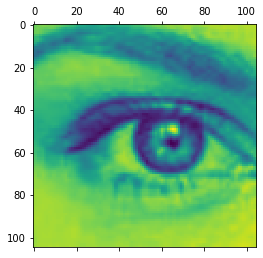

In [5]:
import matplotlib.pyplot as plt
plt.matshow(data[1][0])

## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [6]:
data2= pd.DataFrame(data)
data2[0] = data2[0]/255.0
data2.shape

(9220, 2)

In [7]:
X_train = data2[0]
X_train = X_train.to_numpy()
y_train = data2[1]
#X_train[0].shape
X_train_flat = []
for i in range(len(X_train)):
  #X_train[i] = X_train[i].reshape(1,(105*105))
  X_train_flat.append(X_train[i])
#X_train=X_train.reshape(len(X_train),(105*105))
y_train = y_train.replace({'male':0,'female':1})
import numpy as np
X_train_flat = np.array(X_train_flat).reshape(len(X_train),105, 105, 1)
X_train_flat.shape

(9220, 105, 105, 1)

In [8]:
X_train_flat, X_valid, y_train, y_valid = train_test_split(X_train_flat,y_train,test_size=0.2)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

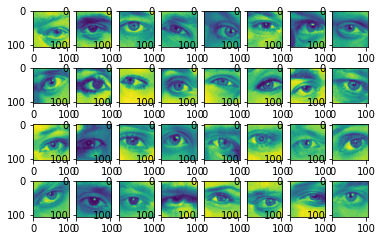

In [10]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(X_train_flat, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [11]:
datagen.fit(X_train_flat)

## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [12]:
from tensorflow import keras
from keras import Sequential
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(111, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(105, 105, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(80, (3, 3), strides=1, padding="same", activation="relu"))
#model.add(Conv2D(70, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=620, activation="relu"))
#model.add(Dense(units=501, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=390, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 105, 105, 111)     1110      
_________________________________________________________________
batch_normalization (BatchNo (None, 105, 105, 111)     444       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 111)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 80)        80000     
_________________________________________________________________
dropout (Dropout)            (None, 53, 53, 80)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 53, 80)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 80)        0

In [13]:
from numpy.random import seed
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
tf.random.set_seed(6)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [14]:
model.fit(img_iter,
          epochs=12,batch_size=36,
          steps_per_epoch=len(X_train_flat)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_valid, y_valid), callbacks=[es])

Epoch 1/12
230/230 [==============================] - 18s 45ms/step - loss: 1.2812 - accuracy: 0.6221 - val_loss: 1.5660 - val_accuracy: 0.5342
Epoch 2/12
230/230 [==============================] - 10s 42ms/step - loss: 0.5527 - accuracy: 0.7377 - val_loss: 1.0708 - val_accuracy: 0.5423
Epoch 3/12
230/230 [==============================] - 9s 39ms/step - loss: 0.4594 - accuracy: 0.7915 - val_loss: 0.4343 - val_accuracy: 0.7842
Epoch 4/12
230/230 [==============================] - 9s 38ms/step - loss: 0.4145 - accuracy: 0.8250 - val_loss: 0.3717 - val_accuracy: 0.8454
Epoch 5/12
230/230 [==============================] - 9s 39ms/step - loss: 0.3622 - accuracy: 0.8396 - val_loss: 0.3373 - val_accuracy: 0.8438
Epoch 6/12
230/230 [==============================] - 11s 47ms/step - loss: 0.3495 - accuracy: 0.8478 - val_loss: 0.3420 - val_accuracy: 0.8536
Epoch 7/12
230/230 [==============================] - 10s 43ms/step - loss: 0.2916 - accuracy: 0.8788 - val_loss: 0.2884 - val_accuracy: 0.

## Validate the model


In [15]:
# for train dataset
y_pred_train = model.predict(X_train_flat)
y_pred_label = []
for i in range(len(y_pred_train)):
    if(y_pred_train[i]>=0.5):
        y_pred_label.append(1)
    else:
        y_pred_label.append(0)

In [16]:
model.evaluate(X_train_flat, y_train)

231/231 [==============================] - 2s 8ms/step - loss: 0.2344 - accuracy: 0.9018


[0.23443055152893066, 0.9018438458442688]

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [17]:
test_labels = pd.read_csv("../input/gendereyedetection/eye_gender_data/Testing_set.csv")  
test_file_paths = [[fname, "../input/gendereyedetection/eye_gender_data/test/" + fname] for fname in labels['filename']]
test_images = pd.DataFrame(test_file_paths, columns=['filename', 'filepaths'])
test_data = pd.merge(test_images, test_labels, how = 'inner', on = 'filename')
#test_data=test_images.copy()

data = []     # initialize an empty numpy array
test_image_size = 105      # image size taken is 100 here. one can take other size too
for i in range(len(test_data)):
  
  img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (test_image_size, test_image_size))      # resizing the image array
      #new_img_array = img_array.resize(100,100)
  data.append([new_img_array])
#test_data.head()

## Data Pre-processing on test_data


In [18]:
data2 = pd.DataFrame(data)
data2[0] = data2[0]/255.0
X_test = data2[0]
X_test = X_test.to_numpy()
X_test_flat = []
for i in range(len(X_test)):
  #X_train[i] = X_train[i].reshape(1,10000)
  X_test_flat.append(X_test[i])
#X_train=X_train.reshape(len(X_train),10000)
import numpy as np
X_test_flat = np.array(X_test_flat).reshape(len(X_test),105, 105, 1)
X_test_flat.shape

(2305, 105, 105, 1)

### Make Prediction on Test Dataset
Time to make a submission!!!

In [19]:
y_test_pred = model.predict(X_test_flat)
y_test_pred_label = []
for i in range(len(y_test_pred)):
    if(y_test_pred[i]>=0.5):
        y_test_pred_label.append(1)
    else:
        y_test_pred_label.append(0)
y_test_pred_label = pd.Series(y_test_pred_label)
y_test_pred_label = y_test_pred_label.replace({0:'male',1:'female'})


## **How to save prediciton results locally via jupyter notebook?**
If you are working on Jupyter notebook, execute below block of codes. A file named 'submission.csv' will be created in your current working directory.

In [20]:
res = pd.DataFrame({'label': y_test_pred_label})
res.to_csv("submission.csv", index = False) 

# **OR,**
**If you are working on Google Colab then use the below set of code to save prediction results locally**

## **How to save prediction results locally via colab notebook?**
If you are working on Google Colab Notebook, execute below block of codes. A file named 'prediction_results' will be downloaded in your system.

# **Well Done! 👍**
You are all set to make a submission. Let's head to the **[challenge page](https://dphi.tech/challenges/4-week-deep-learning-online-bootcamp-final-assignment-sex-determination-by-morphometry-of-eyes/144/submit)** to make the submission.